In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, root_mean_squared_error
from catboost import CatBoostRegressor, Pool
import matplotlib.pyplot as plt
from sklearn.ensemble import HistGradientBoostingRegressor
from joblib import dump
from sklearn.inspection import permutation_importance

# Preprocessing

In [2]:
df = pd.read_csv('C:/Users/mvideo/ho-ho/Решения хакатонов/Ситовые хар-ки/granulometry_v2.csv', encoding='utf-8', delimiter=';')

In [ ]:
dff = df
dff['Время'] = pd.to_datetime(dff['Время'])
dff = dff.dropna()
dff["часы"] = dff["Время"].dt.hour
dff["минуты"] = dff["Время"].dt.minute
dff = dff.drop(columns='Время')

In [4]:
dff = dff.drop(columns=['Мощность МПСИ 2 кВт', 'Мощность МШЦ 2 кВт', 'Ток МПСИ 2 А', 'Ток МШЦ 2 А', 'Исходное питание МПСИ 2 т/ч', 'Возврат руды МПСИ 2 т/ч', 'Общее питание МПСИ 2 т/ч', 
                        'Расход воды МПСИ 2 PV м3/ч', 'Расход воды МПСИ 2 SP м3/ч', 'Расход воды МПСИ 2 CV %', 'факт соотношение руда/вода МПСИ 2', 'Давление на подшипник МПСИ 2 загрузка Бар', 
                        'Давление на подшипник МПСИ 2 разгрузка Бар', 'Обороты насоса 2 1 %', 'Давление в ГЦ насоса 2 1 Бар', 'Расход в ГЦ насоса 2 1 м3/ч', 'Расход оборотной воды 2 м3/ч', 'Гранулометрия 2 %', 
                        'Поток 2 л/мин'])

In [5]:
X = dff.drop(columns=['Гранулометрия 1 %'])
y = dff['Гранулометрия 1 %'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

train_pool = Pool(X_train, y_train)
eval_pool = Pool(X_test, y_test)

# CatBoost

In [6]:
CB = CatBoostRegressor(
    loss_function='RMSE',         
    iterations=5000,             
    depth=5,                      
    learning_rate=0.08,
    subsample=0.95,                 
    colsample_bylevel=0.95,         
    l2_leaf_reg=1,              
    min_data_in_leaf=25,           
    thread_count=1,               
    eval_metric='RMSE',   
    verbose=10                   
)

CB.fit(
    train_pool,
    eval_set=[eval_pool],
    verbose=10
)

results = CB.get_evals_result()

0:	learn: 36.3478704	test: 36.2827596	best: 36.2827596 (0)	total: 269ms	remaining: 22m 22s
10:	learn: 16.3397756	test: 16.2975122	best: 16.2975122 (10)	total: 1.08s	remaining: 8m 11s
20:	learn: 7.9891386	test: 7.9496004	best: 7.9496004 (20)	total: 1.86s	remaining: 7m 21s
30:	learn: 4.7661663	test: 4.7300769	best: 4.7300769 (30)	total: 2.63s	remaining: 7m 2s
40:	learn: 3.6697168	test: 3.6358882	best: 3.6358882 (40)	total: 3.41s	remaining: 6m 52s
50:	learn: 3.2884630	test: 3.2518647	best: 3.2518647 (50)	total: 4.13s	remaining: 6m 40s
60:	learn: 3.0646117	test: 3.0372855	best: 3.0372855 (60)	total: 4.91s	remaining: 6m 37s
70:	learn: 2.9412862	test: 2.9143803	best: 2.9143803 (70)	total: 5.64s	remaining: 6m 31s
80:	learn: 2.8350684	test: 2.8101376	best: 2.8101376 (80)	total: 6.39s	remaining: 6m 28s
90:	learn: 2.7534640	test: 2.7272011	best: 2.7272011 (90)	total: 7.17s	remaining: 6m 26s
100:	learn: 2.6913232	test: 2.6648543	best: 2.6648543 (100)	total: 7.91s	remaining: 6m 23s
110:	learn: 2.6

In [7]:
pred_train_CB = CB.predict(X_train)
pred_test_CB = CB.predict(X_test)

print(f'TRAIN:\nR2 Score: {r2_score(pred_train_CB, y_train)}')
print(f'MAE: {mean_absolute_error(pred_train_CB, y_train)}')
print(f'MSE: {mean_squared_error(pred_train_CB, y_train)}')

print(f'\nTEST:\nR2 Score: {r2_score(pred_test_CB, y_test)}')
print(f'MAE: {mean_absolute_error(pred_test_CB, y_test)}')
print(f'MSE: {mean_squared_error(pred_test_CB, y_test)}')

TRAIN:
R2 Score: 0.9996109456135491
MAE: 0.38133752739586424
MSE: 0.6048124537299124

TEST:
R2 Score: 0.9992686137754292
MAE: 0.4341072806714968
MSE: 1.13278719321964


[4.42487518e-02 3.30967530e-02 4.42151230e-02 7.10162985e-02
 2.09324299e-02 6.71246461e-02 7.60554955e-03 5.82522523e-02
 2.01296779e-02 2.57599699e-02 2.79257096e-03 2.60130006e-01
 2.23910110e-01 5.66779113e-02 4.14743633e-02 9.62096037e-02
 1.29232066e-01 9.26717855e-02 6.07917146e-02 5.01258776e-02
 1.56242022e-01 3.32156355e-02 7.08018715e-02 5.39135424e-02
 5.10367600e-02 2.46731122e-02 5.49403509e-02 2.22666223e-01
 2.41008092e-01 5.72003711e-01 9.70854796e+01 2.46987410e-02
 2.92289402e-03]


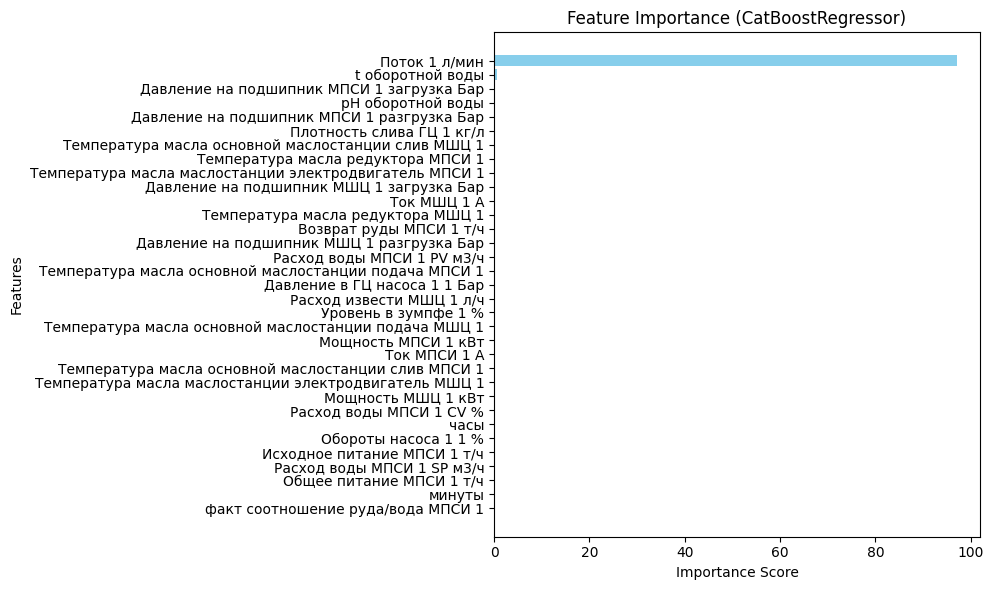

In [8]:
feature_importance = CB.get_feature_importance()

feature_names = X_train.columns
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
})

# Сортировка по важности
importance_df = importance_df.sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['feature'], importance_df['importance'], color='skyblue')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.title('Feature Importance (CatBoostRegressor)')
plt.gca().invert_yaxis()  # Самые важные признаки сверху
plt.tight_layout()

print(CB.get_feature_importance())
plt.show()

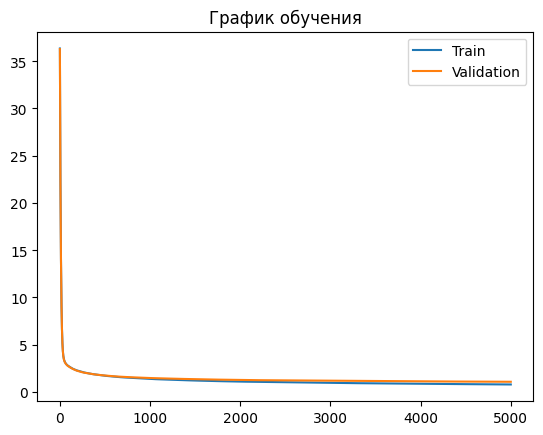

In [9]:
results = CB.get_evals_result()
plt.plot(results['learn']['RMSE'], label='Train')
plt.plot(results['validation']['RMSE'], label='Validation')
plt.title('График обучения')
plt.legend()
plt.show()

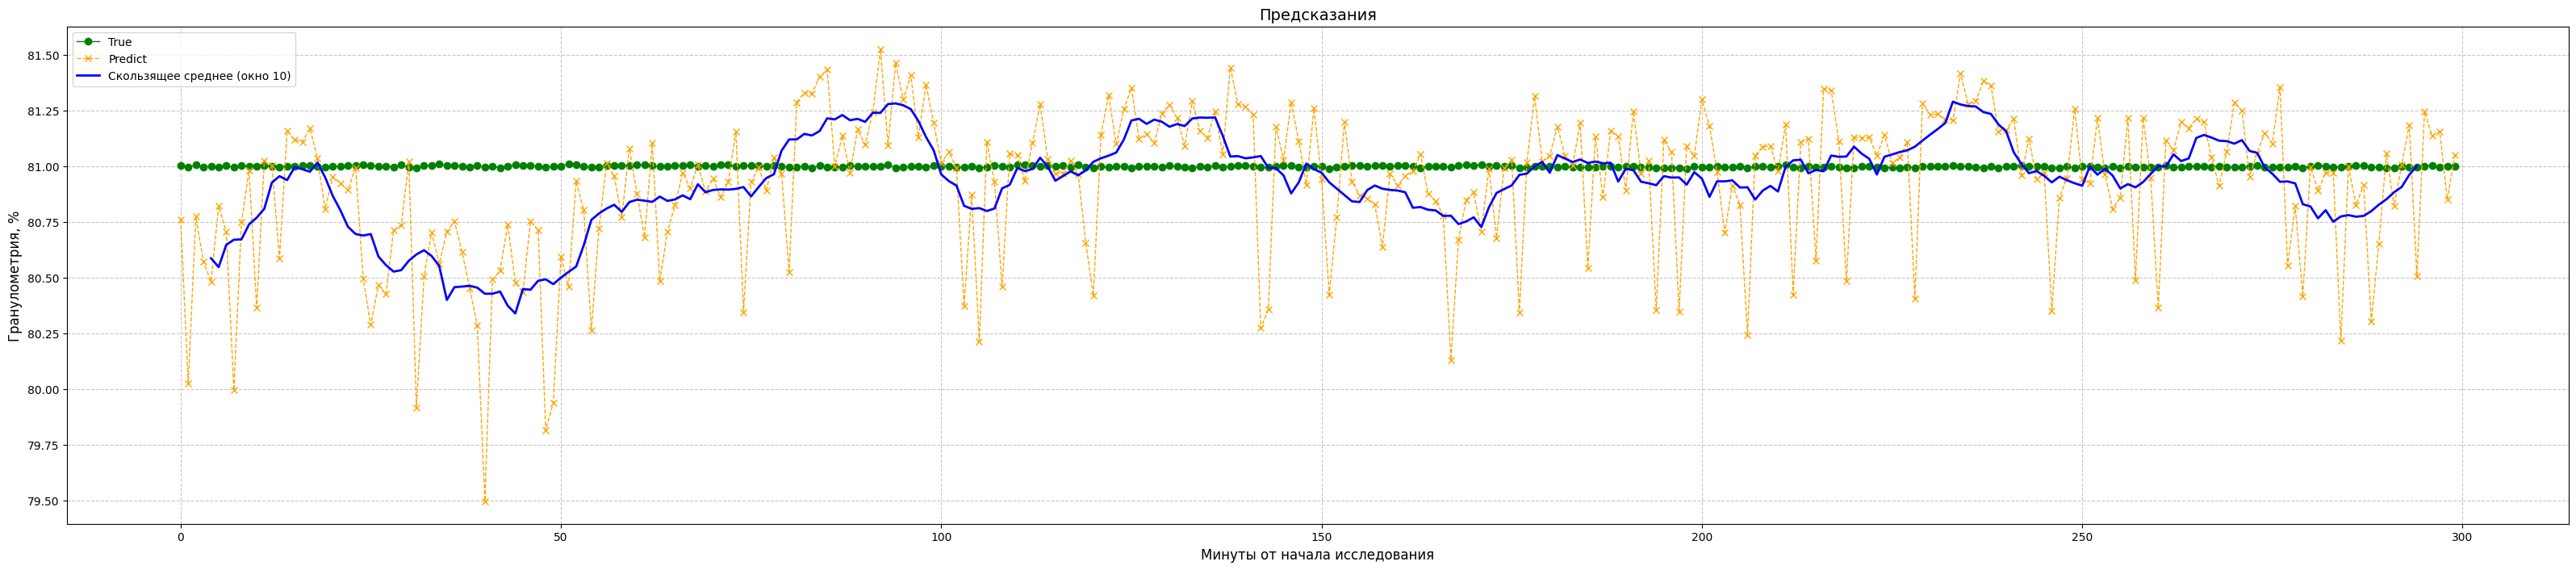

In [10]:
trand_X = dff.drop(columns=['Гранулометрия 1 %']).iloc[1000:1300]
trand_y = dff['Гранулометрия 1 %'].iloc[1000:1300]
res = CB.predict(trand_X)

window_size = 10
moving_avg = np.convolve(res, np.ones(window_size)/window_size, mode='valid')

x1 = list(range(len(trand_y)))
x_moving_avg = x1[(window_size//2):-(window_size//2)] if window_size % 2 == 1 else x1[(window_size//2)-1:-(window_size//2)]

plt.figure(figsize=(40, 8))

plt.plot(x1, trand_y, color='green', marker='o', linestyle='-', linewidth=1, label='True')
plt.plot(x1, res, color='orange', marker='x', linestyle='--', linewidth=1, label='Predict')
plt.plot(x_moving_avg, moving_avg, color='blue', linewidth=2, label=f'Скользящее среднее (окно {window_size})')

plt.xlabel('Минуты от начала исследования', fontsize=12) 
plt.ylabel('Гранулометрия, %', fontsize=12)   
plt.title('Предсказания', fontsize=14)
plt.legend(loc='upper left')               
plt.grid(True, linestyle='--', alpha=0.7)  

plt.show()
#plt.savefig('plot_trand.png')

In [11]:
CB.save_model('C:/Users/mvideo/ho-ho/Решения хакатонов/Ситовые хар-ки/Models/CatBoost_model.cbm')

# Hist GB

In [12]:
mmd = HistGradientBoostingRegressor(loss='squared_error', max_iter=850, max_depth=7, learning_rate=0.3, random_state=42, max_features=0.95)
mmd.fit(X_train, y_train)

,loss,'squared_error'
,quantile,None
,learning_rate,0.3
,max_iter,850
,max_leaf_nodes,31
,max_depth,7
,min_samples_leaf,20
,l2_regularization,0.0
,max_features,0.95
,max_bins,255
,categorical_features,'from_dtype'


In [13]:
pred_mmd_train = mmd.predict(X_train)
pred_mmd_test = mmd.predict(X_test)

print(f'TRAIN\n{r2_score(pred_mmd_train, y_train)}\n{mean_absolute_error(pred_mmd_train, y_train)}\n{mean_squared_error(pred_mmd_train, y_train)}\n')
print(f'TEST\n{r2_score(pred_mmd_test, y_test)}\n{mean_absolute_error(pred_mmd_test, y_test)}\n{mean_squared_error(pred_mmd_test, y_test)}\n\n')

TRAIN
0.9997635034578543
0.27544793149254515
0.3677977648631929

TEST
0.9993456104219649
0.38682464187589394
1.0138962047201543




In [22]:
dump(mmd, 'C:/Users/mvideo/ho-ho/Решения хакатонов/Ситовые хар-ки/Models/HistGradientBoostingRegressor.joblib')

['C:/Users/mvideo/ho-ho/Решения хакатонов/Ситовые хар-ки/Models/HistGradientBoostingRegressor.joblib']

In [16]:
result = permutation_importance(mmd, X_test, y_test, n_repeats=10, random_state=42)
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': result.importances_mean
}).sort_values('Importance', ascending=False)

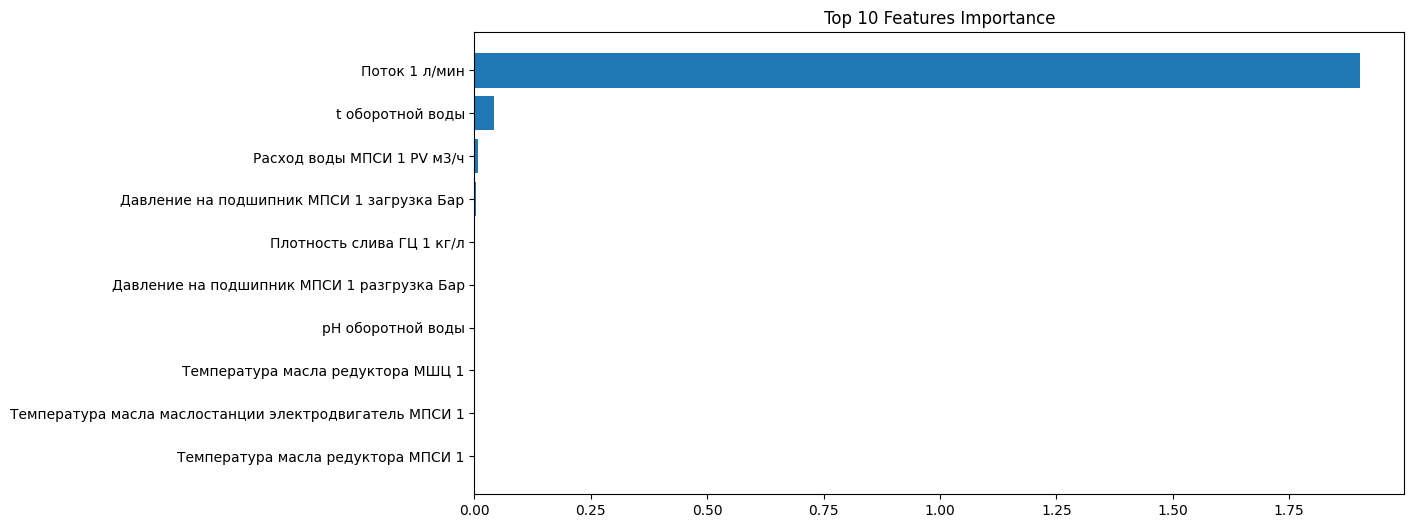

In [18]:
plt.figure(figsize=(12, 6))
plt.barh(importance_df['Feature'][:10], importance_df['Importance'][:10])
plt.gca().invert_yaxis()
plt.title('Top 10 Features Importance')
plt.show()

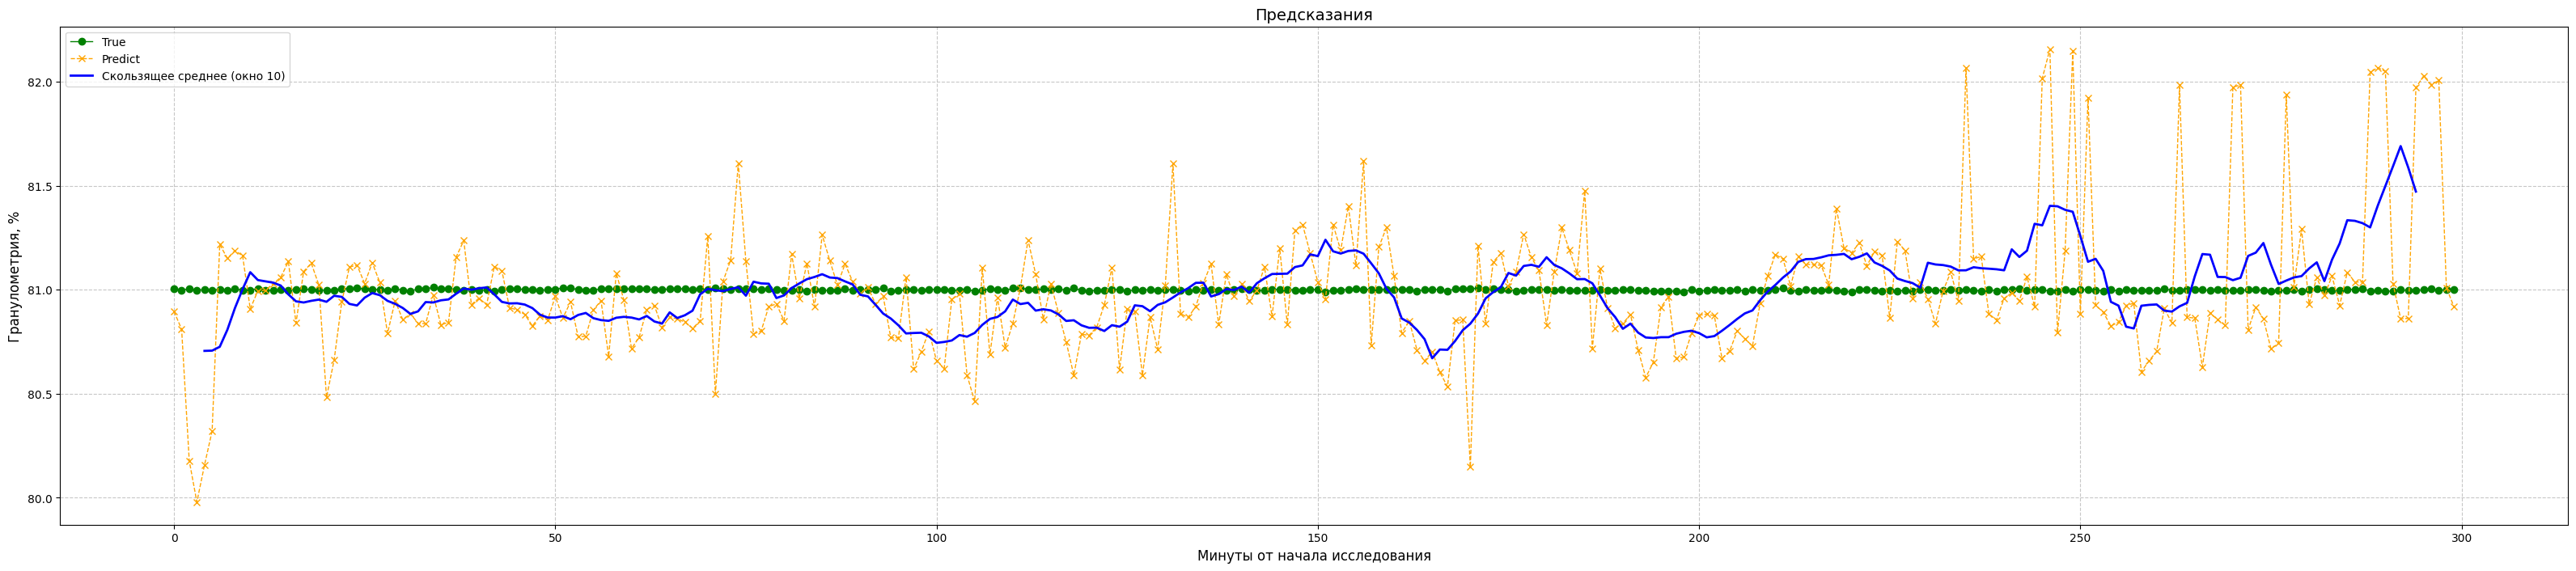

In [19]:
trand_X = dff.drop(columns=['Гранулометрия 1 %']).iloc[1000:1300]
trand_y = dff['Гранулометрия 1 %'].iloc[1000:1300]
res = mmd.predict(trand_X)

window_size = 10
moving_avg = np.convolve(res, np.ones(window_size)/window_size, mode='valid')

x1 = list(range(len(trand_y)))
x_moving_avg = x1[(window_size//2):-(window_size//2)] if window_size % 2 == 1 else x1[(window_size//2)-1:-(window_size//2)]

plt.figure(figsize=(40, 8))

plt.plot(x1, trand_y, color='green', marker='o', linestyle='-', linewidth=1, label='True')
plt.plot(x1, res, color='orange', marker='x', linestyle='--', linewidth=1, label='Predict')
plt.plot(x_moving_avg, moving_avg, color='blue', linewidth=2, label=f'Скользящее среднее (окно {window_size})')

plt.xlabel('Минуты от начала исследования', fontsize=12) 
plt.ylabel('Гранулометрия, %', fontsize=12)   
plt.title('Предсказания', fontsize=14)
plt.legend(loc='upper left')               
plt.grid(True, linestyle='--', alpha=0.7)  

plt.show()
#plt.savefig('plot_trand.png')

# Blending

In [20]:
pred_mean = (pred_mmd_test + pred_test_CB) / 2
root_mean_squared_error(pred_mean, y_test)

0.9736927319846164

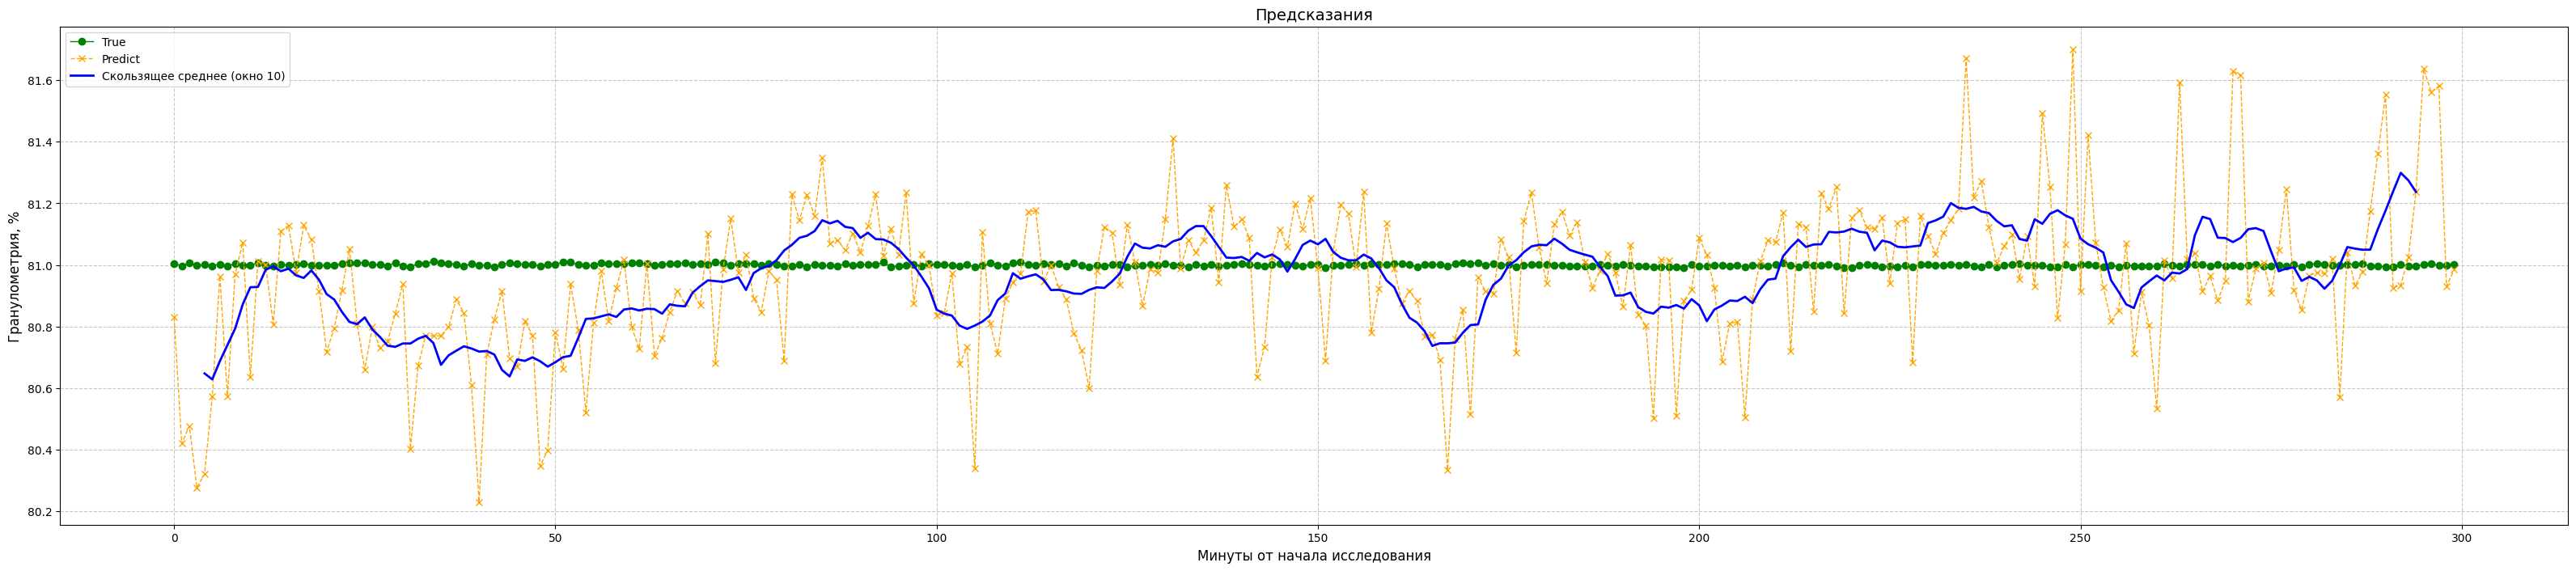

In [21]:
trand_X = dff.drop(columns=['Гранулометрия 1 %']).iloc[1000:1300]
trand_y = dff['Гранулометрия 1 %'].iloc[1000:1300]
res_CB = CB.predict(trand_X)
res_mmd = mmd.predict(trand_X)
res = (res_CB + res_mmd) / 2

window_size = 10
moving_avg = np.convolve(res, np.ones(window_size)/window_size, mode='valid')

x1 = list(range(len(trand_y)))
x_moving_avg = x1[(window_size//2):-(window_size//2)] if window_size % 2 == 1 else x1[(window_size//2)-1:-(window_size//2)]

plt.figure(figsize=(40, 8))

plt.plot(x1, trand_y, color='green', marker='o', linestyle='-', linewidth=1, label='True')
plt.plot(x1, res, color='orange', marker='x', linestyle='--', linewidth=1, label='Predict')
plt.plot(x_moving_avg, moving_avg, color='blue', linewidth=2, label=f'Скользящее среднее (окно {window_size})')

plt.xlabel('Минуты от начала исследования', fontsize=12) 
plt.ylabel('Гранулометрия, %', fontsize=12)   
plt.title('Предсказания', fontsize=14)
plt.legend(loc='upper left')               
plt.grid(True, linestyle='--', alpha=0.7)  

plt.show()
#plt.savefig('Blanding.png')